# Generating survey metadata using waveglider positions

This notebook helps a user locate the start and stop times of different surveys patterns when no survey metadata exists. If survey metadata already exists and you wish to refine start and stop times of existing metadata, please use the `refine_survey_metadata` notebook instead. 
***
## Import Packages

In [ ]:
import os
from pathlib import Path
import json
import pandas as pd
from datetime import datetime, timedelta
import tiledb
import numpy as np
from matplotlib import pyplot as plt, colors as mcolors, cm, dates as mdates
from typing import List

# ES-SFGTools imports
from es_sfgtools.processing.pipeline import DataHandler
from es_sfgtools.utils.archive_pull import list_survey_files
from es_sfgtools.utils.metadata.site import import_site, TopLevelSiteGroups, SubLevelSiteGroups
from es_sfgtools.utils.metadata.campaign import Survey, campaign_checks

***
## Set survey parameters

1. Input survey releated metadata including...
* **network name** - name of network the site belongs to
* **site name** - 4 character site name
* **campaign name** (e.g YYYY_A_VESS) - check the metadata file to ensure you have the correct campaign name
* **vessel type** (e.g SV2 or SV3) - this type will determine which pipeline to run

2. Set the local directory you wish to use to store campaign files, logs, and tileDB arrays. It will be created if it does not yet exist.

In [16]:
# Input survey parameters
network = 'cascadia-gorda'
site = 'NBR1'
campaign_name = '2023_A_1063'   
vessel_type = 'SV3'             # SV2 or SV3 is supported

# Set data directory path for local environment
directory = './data/sfg'

# This will creates data directory if it does not exist
data_dir = Path(f"{os.path.expanduser(directory)}")
os.makedirs(data_dir, exist_ok=True)
print(f"Data directory: {data_dir}")

# Add local survey plots directory
plots_dir = directory + '/campaign_plots'
plots_dir = Path(f"{os.path.expanduser(plots_dir)}")
os.makedirs(plots_dir, exist_ok=True)
print(f"Plots directory: {plots_dir}")

Data directory: data/sfg
Plots directory: data/sfg/campaign_plots


## Load and inspect existing metadata

Please enter the location of your **metadata file** to import data. Campaign start and end dates will be saved for setting up the `DataHandler` class in the next step.

*If no campaign is displayed, ensure you have the correct campaign name in the cell above and re-run if neccessary.*



In [4]:
# Enter the path to the metadata file
metadata_uri = "./site_vessels/NBR1.2025-03-19.json"    

# Load and inspect existing metadata
print(f"Loading site metadata from {metadata_uri} ... \n")
site_metadata = import_site(metadata_uri)

campaign_check = False
start = None
end = None


for campaign in site_metadata.campaigns:
    if campaign.name == campaign_name:
        campaign_check = True
        start = campaign.start
        end = campaign.end
        print(f"  Campaign: {campaign.name} \n   Start: {start} \n    End: {end}\n")

        for survey in campaign.surveys:
            print(f"  Survey: {survey.id} \n   Start: {survey.start} \n    End: {survey.end}")
            surveys.append(survey)
        
        if len(surveys) > 0:
            print(f"Found {len(surveys)} surveys in {campaign.name} campaign. If you wish to refine these surveys instead, please use the refine_survey_metadata notebook.")

        break

if not campaign_check:
    print(f"Campaign {campaign_name} not found in site metadata. Please create the campaign metadata below.")
else: 
    print(f"Campaign {campaign_name} found in site metadata. Proceed to create more surveys below.")


Loading site metadata from ./site_vessels/NBR1.2025-03-19.json ... 

Campaign 2023_A_1063 not found in site metadata. Please create the campaign metadata below.


## Set up the data handler class with our survey parameters

This will set up a `DataHandler` class using our data directory and site related information we set above. By doing this, the data handler will populate our data directory with the necessary folders and tileDB arrays. This cell also grab the correct pipeline for the vessel type specified (SV2/SV3).

In [ ]:
# Set up the DataHandler class
data_handler = DataHandler(directory=data_dir) 

# Set the survey parameters
data_handler.change_working_station(network=network, 
                                    station=site, 
                                    campaign=campaign_name) 
                                    # start_date=start.date(),    # Start date of the campaign (time not accepted)
                                    # end_date=end.date())        # End date of the campaign (time not accepted)

if vessel_type == 'SV3':
    pipeline, config = data_handler.get_pipeline_sv3()
elif vessel_type == 'SV2':
    pipeline, config = data_handler.get_pipeline_sv2()
else:
    raise ValueError(f"Vessel type {vessel_type} not recognized")


Building directory structure for cascadia-gorda NBR1 2023_A_1063
No date range set for cascadia-gorda, NBR1, 2023_A_1063
Building TileDB arrays for NBR1
Changed working station to cascadia-gorda NBR1


# Get the acoustic (DFOP00) files from the EarthScope archive

This will go to the EarthScope archive and list files for the specific campaign. The `DataHandler` class will then add this remote file list to the catalog stored within our data directory set above. It will then download only the DFOP00 files to our data directory. 

*If you have already run this cell prior, it will likely not need to download the files again.*

In [6]:
# Get DFOP00 file list from the archive
remote_filepaths = list_survey_files(network=network, station=site, survey=campaign_name)

# Add the data to the data handler
data_handler.add_data_remote(remote_filepaths=remote_filepaths)

# Download the dfop00 files, if not already downloaded (override=False)
data_handler.download_data(file_types='dfop00', override=False)

Listing survey files from url https://gage-data.earthscope.org/archive/seafloor/cascadia-gorda/NBR1/2023_A_1063/raw
Found under https://gage-data.earthscope.org/archive/seafloor/cascadia-gorda/NBR1/2023_A_1063/raw:
    107 NOV000 file(s)
    44 NOV770 file(s)
    7 DFOP00 file(s)
23 files not recognized and skipped
Added 0 out of 151 files to the catalog
No new AssetType.DFOP00 files to download


## Read DFOP00 files into shotdata array

Using the SV pipeline chosen above, we will create an array from the DFOp00 files.

In [7]:
# Read DFOP00 files into shotdata array
config.dfop00_config.override=True          # Flag to override existing data
pipeline.config = config
pipeline.process_dfop00()

Found 7 DFOP00 Files to Process
Processing DFOP00 Files:   0%|          | 0/7 [00:00<?, ?it/s]Found 0 overlapping ping-reply sequences
Found 0 overlapping ping-reply sequences
Found 0 overlapping ping-reply sequences
Found 0 overlapping ping-reply sequences
Found 1 overlapping ping-reply sequences
Found 0 overlapping ping-reply sequences
Found 0 overlapping ping-reply sequences
Processing DFOP00 Files: 100%|██████████| 7/7 [00:17<00:00,  2.55s/it]
Generated 7 ShotData dataframes From 7 DFOP00 Files


## Convert data from array into a dataframe

In [8]:
## Set the shotdata array URI
shotdata_uri = f"{directory}/{network}/{site}/TileDB/shotdata_db.tdb"

# Read data from the TileDB array
with tiledb.open(shotdata_uri, mode="r") as array:
    shot_data_dataframe = array.df[:]

# Show preview of the data
shot_data_dataframe

,triggerTime,transponderID,head0,pitch0,roll0,head1,pitch1,roll1,east0,north0,...,east_std,north_std,up_std,pingTime,returnTime,tt,dbv,xc,snr,tat
0,2023-09-27 01:17:28.870,5209,338.070160,2.122945,0.940730,326.522461,-3.620501,-0.854208,-2724752.50,-3874088.25,...,8.238,13.501,34.5,1.695799e+09,1.695799e+09,2.606950,255,73,31.0,0.20
1,2023-09-27 01:17:43.870,5209,326.232513,-2.844583,-3.690672,315.997192,4.806674,4.020444,-2724745.00,-3874076.75,...,8.252,13.467,34.5,1.695799e+09,1.695799e+09,2.607255,254,93,39.0,0.20
2,2023-09-27 01:17:58.870,5209,339.797394,-4.172258,2.737460,333.300934,-4.016680,-0.690884,-2724737.50,-3874061.50,...,8.252,13.467,34.5,1.695799e+09,1.695799e+09,2.607516,0,88,47.0,0.20
3,2023-09-27 01:18:13.870,5209,316.690033,1.676960,0.279523,330.972046,1.410082,-4.158216,-2724731.75,-3874050.50,...,8.251,13.432,34.5,1.695799e+09,1.695799e+09,2.607881,0,90,40.0,0.20
4,2023-09-27 01:18:28.870,5209,323.334106,5.505106,-9.198886,330.338776,7.139909,21.651999,-2724727.00,-3874036.25,...,8.224,13.297,34.5,1.695799e+09,1.695799e+09,2.611519,249,89,28.0,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64777,2023-10-03 14:31:47.870,5210,128.917999,-4.449618,2.057006,138.548813,0.801051,-0.635402,-2727334.50,-3874916.25,...,8.817,14.158,27.6,1.696365e+09,1.696365e+09,3.285805,242,94,25.0,0.32
64778,2023-10-03 14:32:02.870,5210,126.054733,0.117444,-1.372195,127.243790,-2.356087,1.556560,-2727332.00,-3874925.00,...,7.540,9.930,23.0,1.696365e+09,1.696365e+09,3.286238,242,90,17.0,0.32
64779,2023-10-03 14:32:17.870,5210,116.842865,2.482064,-2.076851,127.696526,-1.795709,-1.196997,-2727328.50,-3874931.75,...,7.538,9.932,23.0,1.696365e+09,1.696365e+09,3.285674,242,93,25.0,0.32
64780,2023-10-03 14:32:32.870,5210,133.133560,9.904222,5.945963,133.664398,-4.671459,-2.559522,-2727323.75,-3874941.50,...,7.535,9.890,23.0,1.696365e+09,1.696365e+09,3.285875,242,90,18.0,0.32


***
## Plot waveglider locations

Now that we have our data ready, we can begin plotting waveglider locations and refining our surveys.

### Set plotting functions
We will use these 2 plotting functions to refine our surveys below. Run the next cell to set these functions.

In [9]:
def plot_en(df, surveys: List[Survey]=[], save_as: str = None):
    """
    Plots the East and North positions over time for a given dataset, with survey periods highlighted.

    Parameters:
    - df: DataFrame containing the survey data with columns like 'triggerTime', 'east0', and 'north0'.
    - surveys: List of survey objects, each containing 'start', 'end', 'type', and optional 'notes'.
    - save_as: Optional string specifying the filename to save the plot. If None, the plot is not saved.
    """

    # Create a figure with two subplots (one for East, one for North)
    fig, axs = plt.subplots(nrows=2, figsize=(16,10))  

    # Set x and y axis labels
    axs[0].set_ylabel("East (m)")
    axs[1].set_ylabel("North (m)")

    # Scatter plot for East positions
    sc0 = axs[0].scatter(
        df["triggerTime"],
        df["east0"],
        alpha=0.25
    )
    # Scatter plot for North positions
    sc1 = axs[1].scatter(
        df["triggerTime"],
        df["north0"],
        alpha=0.25
    )

    # Generate a rainbow colormap for the surveys
    survey_colors = cm.rainbow(np.linspace(0, 1, len(surveys)))
    # Highlight survey periods on both subplots
    for ax in axs:
        for i, survey in enumerate(surveys):
            start = survey.start
            end = survey.end
            label = survey.type + " " + survey.notes if survey.notes else survey.type

            # Highlight the survey period with a colored span
            ax.axvspan(start, end, color=survey_colors[i], alpha=0.3, label=label)
        
        # Make ticks on occurrences of each month:
        ax.xaxis.set_major_locator(mdates.DayLocator())
        
        # Format the x-axis to display dates in 'month-day' format
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    # Rotate x-axis labels 90 degrees
    plt.xticks(rotation=90)

    # Add a legnend to the first subplot
    axs[0].legend()

    # Save the plot to a file if a filename is provided
    if save_as is not None:
        plt.savefig(save_as)
        

def plot_wg_position(df, start: datetime, end: datetime, survey: Survey = None):
    """
    Plots the antenna position (East vs. North) for a specific survey within a given time range.

    Parameters:
    - df: DataFrame containing the survey data with columns like 'triggerTime', 'east0', and 'north0'.
    - start: Start time of the survey (datetime object).
    - end: End time of the survey (datetime object).
    """
    # Filter the DataFrame for the specified time range
    temp_df = df[df['triggerTime']>=start]
    temp_df = temp_df[df['triggerTime']<=end]

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(16,10))

    # Set the title of the plot and the filename for saving the figure
    if survey is not None:
        survey_name = survey.id
        survey_type = survey.type
        title = f"{survey_name} {survey_type} from {start.isoformat()} to {end.isoformat()}"
        save_as = f"{plots_dir}/{survey_name}_{survey_type}.png"
        fig.suptitle(title)
    else:
        title = f"Survey from {start.isoformat()} to {end.isoformat()}"
        save_as = "survey.png"
        fig.suptitle(title)

    # Set the x and y axis labels
    ax.set_xlabel("East (m)")
    ax.set_ylabel("North (m)")

    # Optional: Plot the origin point (?)
    #ax.scatter(0, 0, label="Origin", color="magenta",s=100)

    # Convert trigger times to timestamps and scale them for colormap normalization
    colormap_times = temp_df["triggerTime"].apply(lambda x:x.timestamp()).to_numpy()
    colormap_times_scaled = (colormap_times - colormap_times.min())/3600

    # Normalize the colormap to the range of scaled times
    norm = mcolors.Normalize(
        vmin=0,
        vmax=(colormap_times.max() - colormap_times.min()) / 3600,
    )

    # Scatter plot of East vs. North positions, colored by time
    sc = ax.scatter(
        temp_df["east0"],
        temp_df["north0"],
        c=colormap_times_scaled,
        cmap="viridis",
        label="Antenna Position",
        norm=norm,
        alpha=0.25
    )

    # Add a colorbar to indicate time in hours
    cbar = plt.colorbar(sc,label="Time (hr)",norm=norm)

    # Add a legend to the plot
    ax.legend()

    # Save the plot to a file
    plt.savefig(save_as)

    # Print the start and end times of the filtered data
    print(f"Start Time: {temp_df.triggerTime.iloc[0].isoformat()} \nEnd Time: {temp_df.triggerTime.iloc[-1].isoformat()}")


### Plot the full campaign

This next cell plots the entire shot data dataframe as well as the waveglider map positions. To alter..
1. Run the call and view the full campaign via the plots below
2. Adjust the start and end dates using the +/- `timedelta` function within the start and end date variables.
3. Repeat as necessary to trim the campaign start and end dates


Start Time: 2023-09-27T01:17:28.870000 
End Time: 2023-10-03T14:32:47.870000
Total number of days in campaign: 6 days


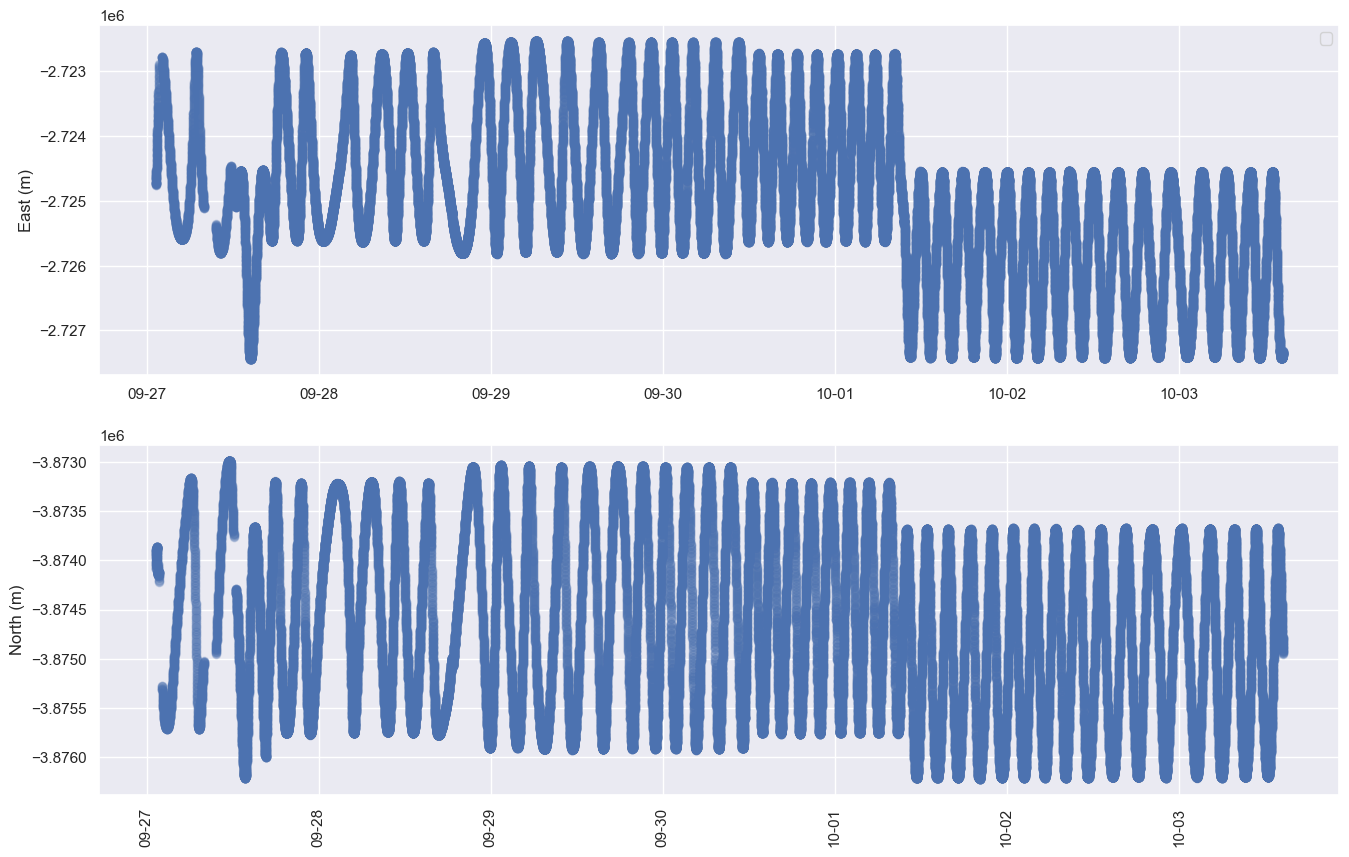

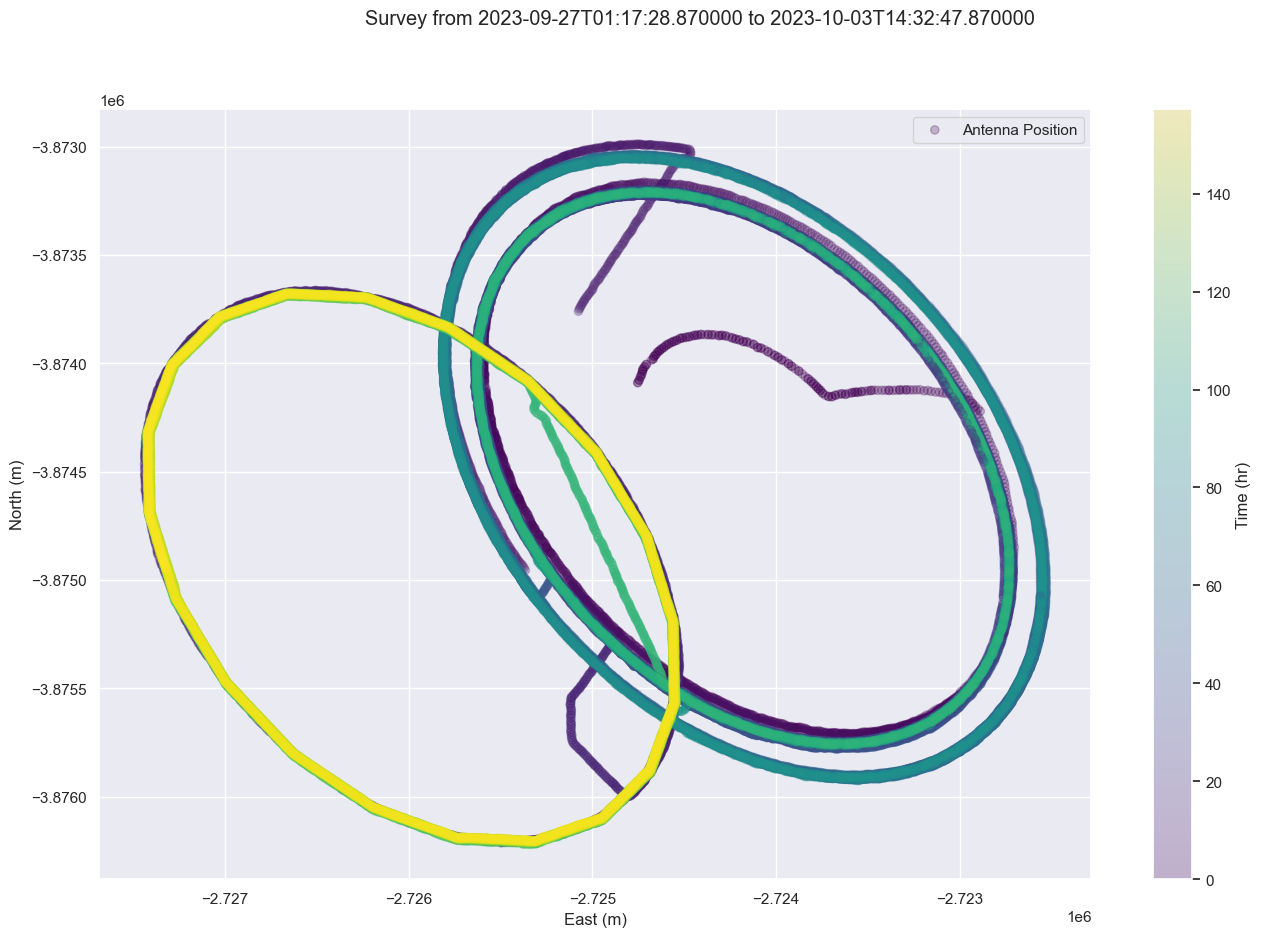

In [10]:
# Adjust to remove any junk data at beginning or end if needed
start = shot_data_dataframe.triggerTime.iloc[0] + timedelta(hours=0, minutes=0)
end = shot_data_dataframe.triggerTime.iloc[-1] - timedelta(hours=0, minutes=0)

# Filter the DataFrame for the specified time range
temp_df = shot_data_dataframe[shot_data_dataframe['triggerTime'] >= start]
temp_df = temp_df[shot_data_dataframe['triggerTime'] <= end]
 
# Plot the East/North positions over time
plot_en(df=temp_df)

# Plot the waveglider position
plot_wg_position(df=shot_data_dataframe, start=start, end=end)

# Print total number of days in survey
print(f"Total number of days in campaign: {(end-start).days} days")

## Create or update the campaign 

If no campaign exists in the metadata, we will need to create that first. If a campaign already exists, skip this section and start working on creating surveys. 

In [11]:
campaign = {}
# ----------------------- Update these values ----------------------- 

# -- Required information for new campaign --
campaign['name'] = campaign_name
campaign['vesselCode'] = campaign_name[-4:]  # Extract the last 4 characters of the campaign name
campaign['start'] = start.isoformat()         # Start date of campaign
campaign['end'] = end.isoformat()            # End date of campaign

campaign['type'] = ""           # type of campaign: deploy | measure 

# -- Optional: Enter information known about the people and vessels involved in the campaign --
campaign['launchVesselName'] = ""             # launch vessel name used in campaign
campaign['recoveryVesselName'] = ""           # recovery vessel name used in campaign
campaign['principalInvestigator'] = ""        # PI name 
campaign['cruiseName'] = ""                   # Name of cruise
campaign['technicianName'] = ""               # technician name
campaign['technicianContact'] = ""            # technician contact information (email/phone)


# ----------------------- Do not update code below ----------------------- 
print(json.dumps(campaign, indent=2))

{
  "name": "2023_A_1063",
  "vesselCode": "1063",
  "start": "2023-09-27T01:17:28.870000",
  "end": "2023-10-03T14:32:47.870000",
  "type": "",
  "launchVesselName": "",
  "recoveryVesselName": "",
  "principalInvestigator": "",
  "cruiseName": "",
  "technicianName": "",
  "technicianContact": ""
}


### Confirm output it correct and then run the next cell to add the campaign to the site metadata

In [12]:
# ----------------------- Do not update code below -----------------------
site_metadata.run_component(component_type=TopLevelSiteGroups.CAMPAIGNS, component_metadata=campaign, add_new=True)

{
  "name": "2023_A_1063",
  "type": "",
  "vesselCode": "1063",
  "start": "2023-09-27T01:17:28.870000",
  "end": "2023-10-03T14:32:47.870000",
  "principalInvestigator": null,
  "launchVesselName": null,
  "recoveryVesselName": null,
  "cruiseName": null,
  "technicianName": null,
  "technicianContact": null,
  "surveys": []
}
New TopLevelSiteGroups.CAMPAIGNS added successfully.


In [ ]:
# If you want to view the entire site metadata, you can print it out
site_metadata.print_json()

*** 
## Plot & create surveys

Now that we have plotted the full campaign, lets narrow down on an individual survey.

Start Time: 2023-09-27T02:17:40.870000 
End Time: 2023-09-27T07:59:32.870000


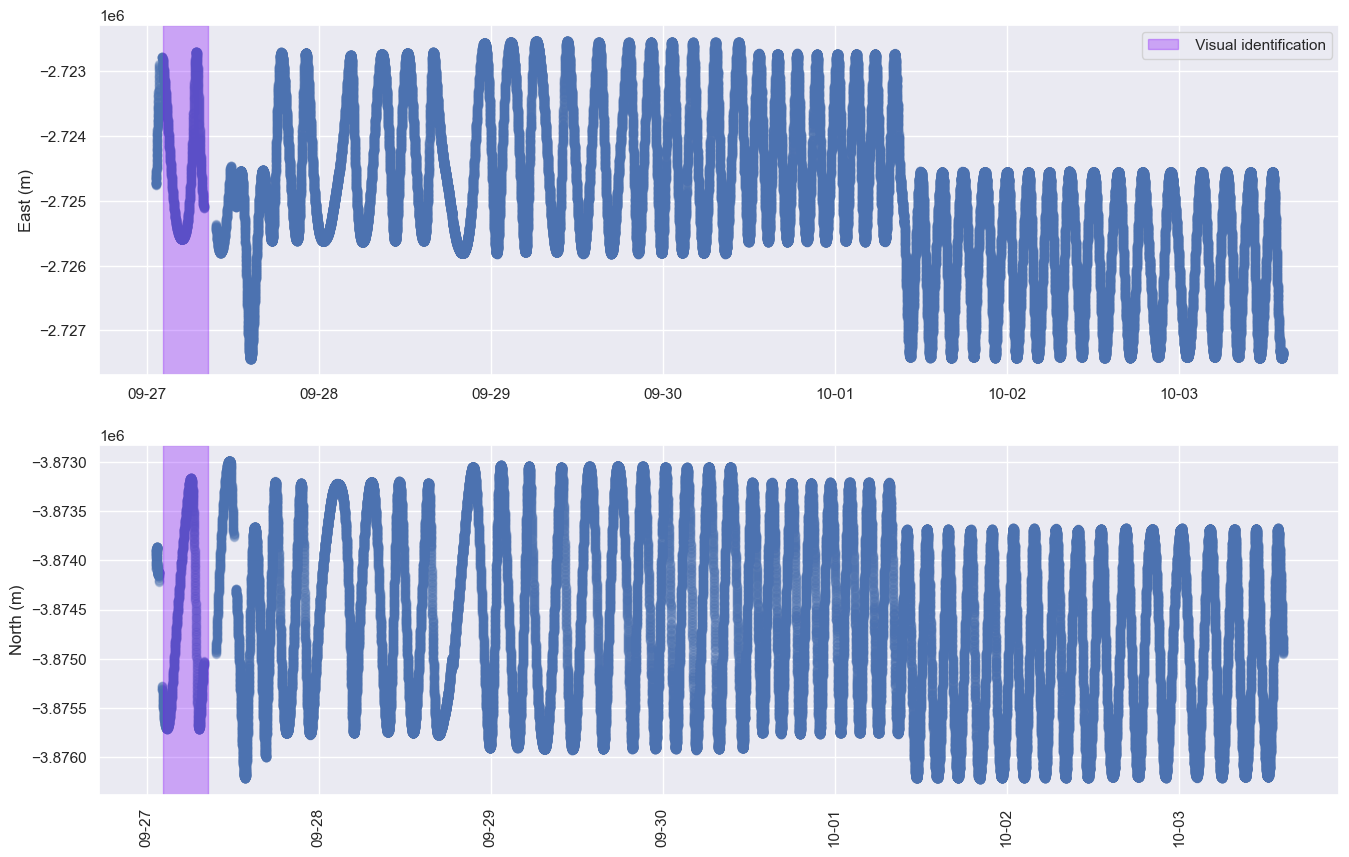

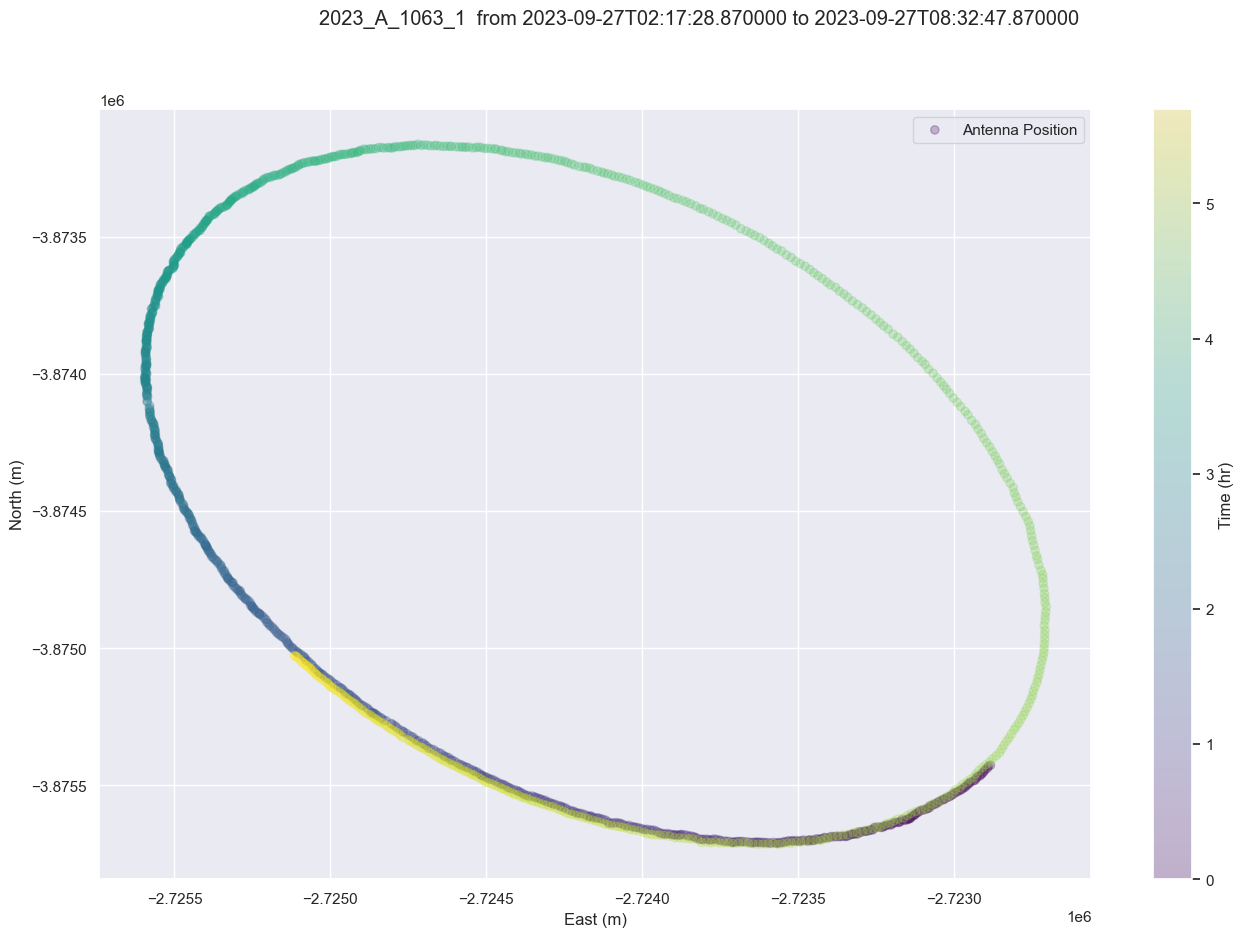

In [ ]:
# Change the survey interval to the next number on each subsequent survey creation
survey_interval = 1

survey_start = start + timedelta(days=0, hours=1, minutes=0)
survey_end = end - timedelta(days=6, hours=6, minutes=0)

# Create a new survey object
survey = Survey(
    id=campaign_name + "_"  + str(survey_interval),
    start=survey_start,
    end=survey_end,
    type="",                                        # If you can identify, add the type of survey: deploy | measure | recover
    benchmarkIDs=[],                                # If you can identify the benchmark IDs, add them here
    notes="Visual identification",                  # Any additional notes about the survey
)

plot_en(temp_df, [survey])
plot_wg_position(df=shot_data_dataframe, start=survey.start, end=survey.end, survey=survey)

## Add the survey to our metadata

Once you have narrowed down your survey and any associated metadata, run the next cell to add it to the metadata class. If you wish to create more surveys, repeat the **Create Survey** step above. If you want to see all surveys so far, run the 2 plot cells below to check it out.

In [18]:
site_metadata.run_sub_component(component_type=TopLevelSiteGroups.CAMPAIGNS, component_name=campaign_name,
                            sub_component_type=SubLevelSiteGroups.SURVEYS, sub_component_metadata=survey.__dict__,
                            add_new=True)

{
  "id": "2023_A_1063_1",
  "type": "",
  "benchmarkIDs": [],
  "start": "2023-09-27T02:17:28.870000",
  "end": "2023-09-27T08:32:47.870000",
  "notes": "Visual identification",
  "commands": null
}
New survey added successfully.


# Plot East/North plots with each survey shaded over top.


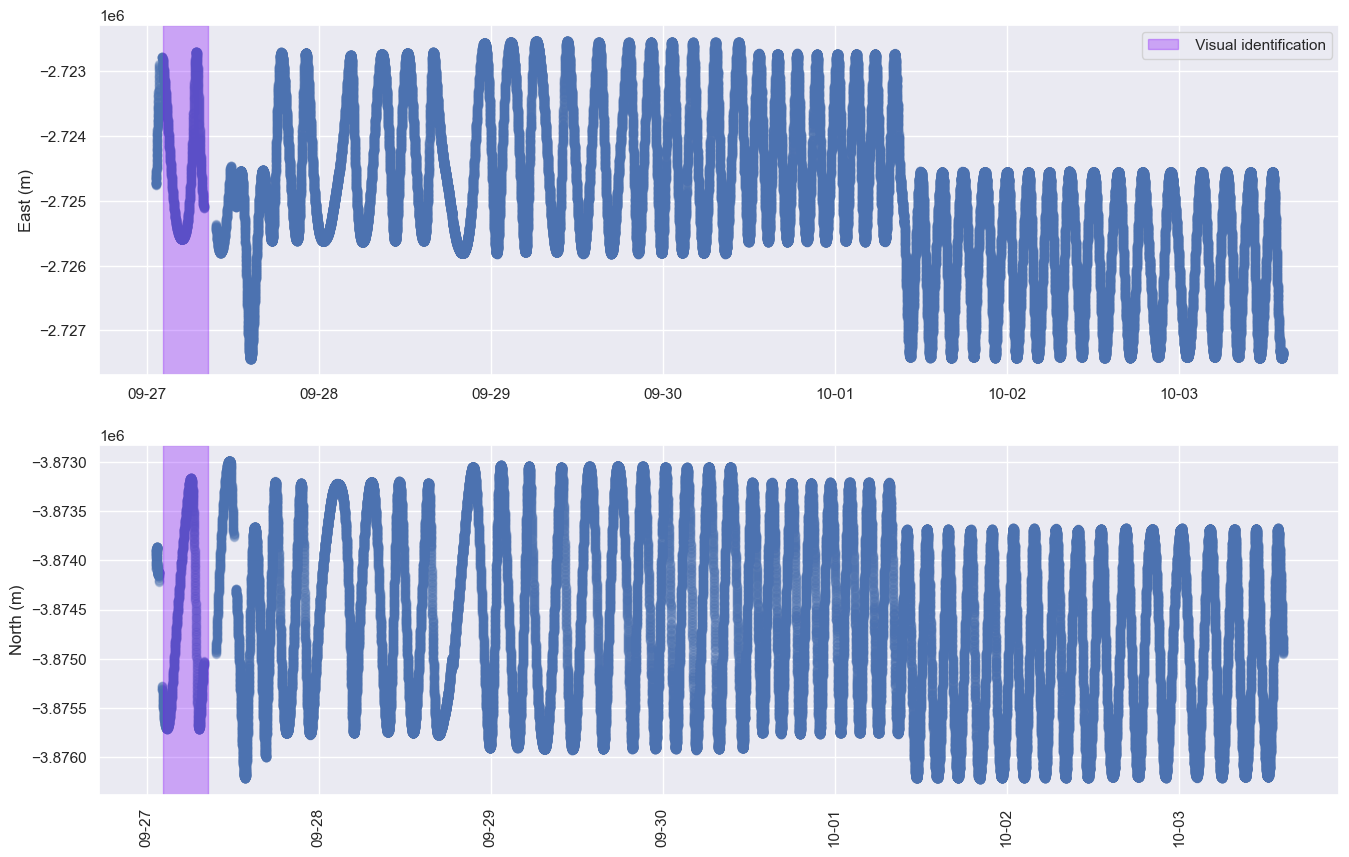

In [19]:
surveys=[]
for campaign in site_metadata.campaigns:
    if campaign.name == campaign_name:
        for survey in campaign.surveys:
            surveys.append(survey)

# Plot the surveys we have so far
plot_en(temp_df, surveys, save_as=f"{plots_dir}/{site}_{campaign_name}_surveys.png")

## Plot all survey maps

Survey: 2023_A_1063_1
Start Time: 2023-09-27T02:17:40.870000 
End Time: 2023-09-27T07:59:32.870000


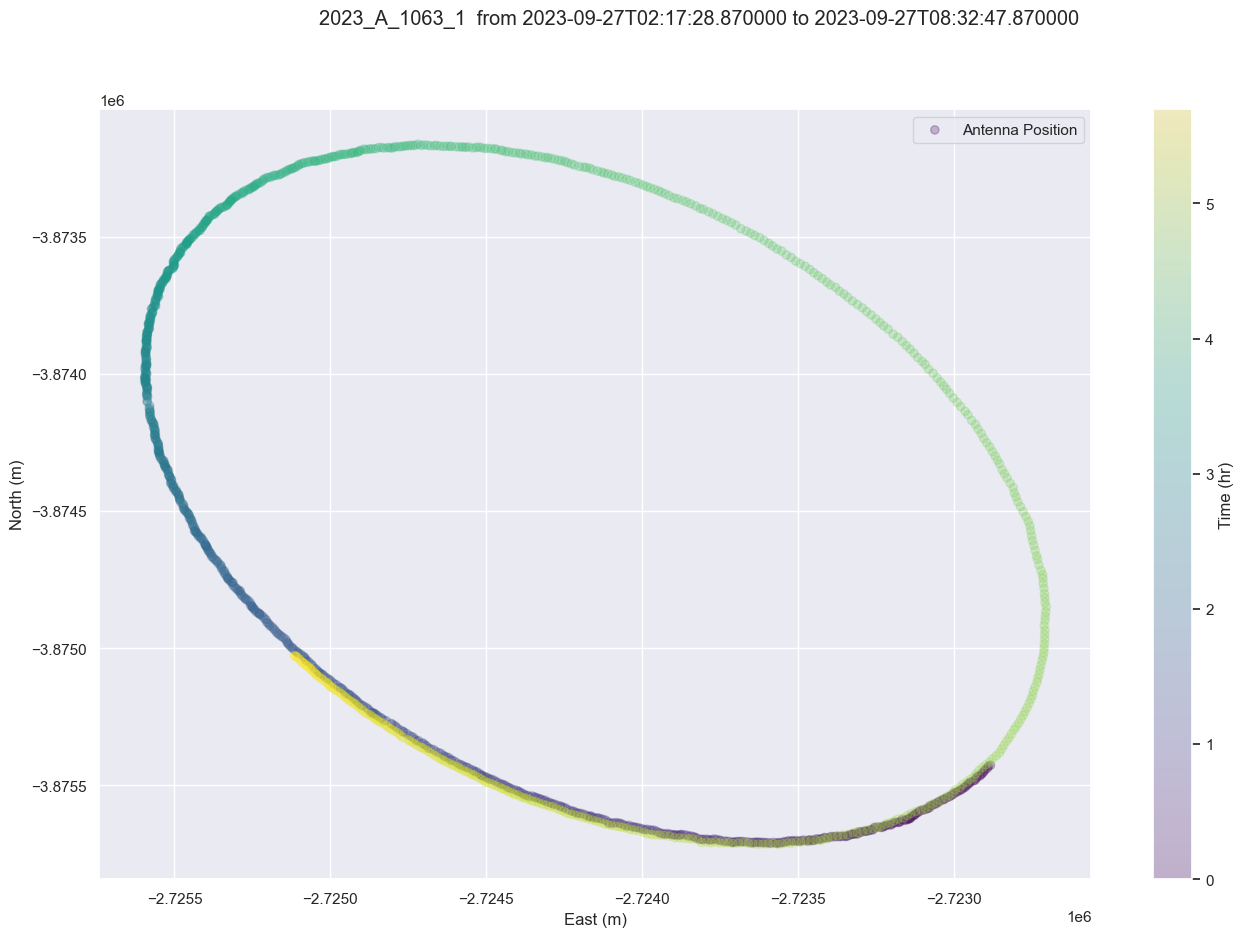

In [20]:
for individual_survey in surveys:
    print(f"Survey: {individual_survey.id}")
    plot_wg_position(df=shot_data_dataframe, start=survey.start, end=survey.end, survey=individual_survey)

# Export updated site metadata to file

Once you have finished identifying and adding survey metadata, save the updated metadata to a file. 

In [ ]:
SITE_4_CHAR_ID = site           # 4 char site ID

if not SITE_4_CHAR_ID:
    raise ValueError("Please enter a 4 char site ID")

# Export site metadata to a json file
# Add date to the file name
date = datetime.now().strftime("%Y-%m-%d")
file_path = f"./{SITE_4_CHAR_ID + '.new_surveys.' + date}.json"          # Export file path you wish to store
site_metadata.export_site(file_path)